In [1]:
import sys
sys.path.append('/Users/celia/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/celia/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as scio
import bandit_preprocessing as bp
import hmm_on_behavior as hob
import calcium_codes as cc
sys.path.append('/Users/celia/GitHub/mouse_bandit/jupyter_notebooks/helper_functions')
sys.path.append('/Users/celia/GitHub/mouse_bandit')
import hf_behavior_imaging as hf
import os
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [552]:
'''Initialize paths and import data'''

record_path = '/Users/celia/GitHub/mouse_bandit/celia_session_record.csv' # session record of behavioral data
#ca_data_path = '/Volumes/Neurobio/MICROSCOPE/Celia/data/imaging/Shay/Extracted/k1_111616_bandit_9010/k1_111616_bandit_9010_neuron_results_rectified'
ca_data_path = '/Volumes/Neurobio/MICROSCOPE/Celia/data/imaging/Shay/Extracted/q43_111716_bandit_8020/q43_111716_bandit_8020_neuron_results.mat'


record = pd.read_csv(record_path,index_col=0) # session record is panda df
ca_data = scio.loadmat(ca_data_path,squeeze_me = True, struct_as_record = False)
neuron = ca_data['neuron_results'] # set neuron variable to just contain neuron_results structure


'''Specify mouse and session of interest'''

session_name  = '09062017_Sky'
mouse_id = 'Sky'

record[record['Session ID'] == session_name] # take only rows from record that match session name


'''Load in trial data from specific session'''

columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked',
           'Right Reward Prob','Left Reward Prob','Reward Given',
          'center_frame','decision_frame']

root_dir = '/Users/celia/GitHub/mouse_bandit/data/trial_data'

full_name = session_name + '_trials.csv'

path_name = os.path.join(root_dir,full_name)

trial_df = pd.read_csv(path_name,names=columns)

FileNotFoundError: File b'/Users/celia/GitHub/mouse_bandit/data/trial_data/09062017_Sky_trials.csv' does not exist

In [549]:
trial_df.shape

(636, 9)

In [453]:
np.set_printoptions(threshold=np.inf)

In [550]:
record[record['Session ID']==session_name]

,Owner,Session ID,Mouse ID,Date,Phase,Markov,Left Reward Prob,Right Reward Prob,Block Range Min,Block Range Max,No. Trials,No. Blocks,No. Rewards,p(high Port),Decision Window Duration,Min Inter-trial-interval,Left Solenoid Duration,Right Solenoid Duration
930,celia,09042017_Raspberry,Raspberry,2017-09-04 00:00:00,2.0,1,0.1,0.9,NaN,NaN,636.0,13.0,479.0,0.82,2.0,1.0,40.0,40.0


In [551]:
reward_prob = 0.1
np.sum(trial_df['Right Reward Prob']==reward_prob)/trial_df.shape[0] # check balance of blocks on each side

blocks = list(np.diff(np.concatenate((range(1),np.where(np.diff(trial_df['Right Reward Prob']) != 0)[0]))))
blocks.append(int(record[record['Session ID']==session_name]['No. Trials'].values)
             -np.where(np.diff(trial_df['Right Reward Prob']) != 0)[0][-1]) # length of the last block at end
blocks

[13, 84, 62, 95, 15, 39, 49, 80, 19, 58, 24, 29, 61, 8]

In [541]:
beliefs = hob.predictBeliefBySession(record_path, session_name, mouse_id) # generate estimate of belief for each trial

columns.append('Belief') # add column named belief to data frame
trial_df['Belief'] = beliefs # insert estimated values of belief into this new column
columns.append('Block ID')

block_id = np.asarray([x+1 for x in range(int(record[record['Session ID']==session_name]['No. Blocks'].values[0])+1)
            for y in range(blocks[x])])
trial_df['Block ID'] = block_id

In [560]:
trial_df.head(5)

,Elapsed Time (s),Since last trial (s),Trial Duration (s),Port Poked,Right Reward Prob,Left Reward Prob,Reward Given,center_frame,decision_frame
0,11.698,1.968,0.438,1,0.1,0.9,0,NaN,NaN
1,17.565,5.340,0.527,1,0.1,0.9,0,NaN,NaN
2,28.229,8.793,0.612,1,0.1,0.9,1,NaN,NaN
3,47.607,19.000,0.378,2,0.1,0.9,1,NaN,NaN
4,53.616,2.824,0.576,2,0.1,0.9,1,NaN,NaN


# convert to feature matrix
### Add column for beliefs using past (n) trials as memory (n <= 10)

In [345]:
feature_matrix = bp.create_feature_matrix(trial_df,10,mouse_id,session_name,feature_names='Default',imaging=True)

beliefs_feat_mat = hob.predictBeliefFeatureMat(feature_matrix, 10) # generate estimates of belief based on feature matrix format

feature_matrix['Belief'] = beliefs_feat_mat # insert estimated values into new column of original feature matrix

In [174]:
feature_matrix[['Port Streak','Decision','Switch', 'Reward', 'Belief']].head(5) # look at only a few columns

,Port Streak,Decision,Switch,Reward,Belief
0,1.0,0.0,0.0,0.0,0.979286
1,2.0,1.0,1.0,0.0,0.828662
2,1.0,1.0,0.0,0.0,0.961635
3,2.0,1.0,0.0,0.0,0.979066
4,3.0,1.0,0.0,0.0,0.981041


In [559]:
feature_matrix.head(10)

,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,...,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,center_frame,decision_frame,Belief
0,Raspberry,08302017_Raspberry,11.0,11.0,7.0,1.0,1.0,0.0,1.0,5.495,...,0.516,1.798,0.562,0.0,0.0,1.0,0.0,NaN,NaN,0.979286
1,Raspberry,08302017_Raspberry,12.0,12.0,7.0,2.0,-1.0,0.0,0.0,2.183,...,0.562,1.763,0.477,1.0,1.0,0.0,0.0,NaN,NaN,0.828662
2,Raspberry,08302017_Raspberry,13.0,13.0,7.0,1.0,-2.0,0.0,1.0,2.864,...,0.477,2.322,0.551,1.0,0.0,0.0,0.0,NaN,NaN,0.961635
3,Raspberry,08302017_Raspberry,14.0,14.0,7.0,2.0,-3.0,0.0,1.0,1.802,...,0.551,3.382,0.588,1.0,0.0,0.0,0.0,NaN,NaN,0.979066
4,Raspberry,08302017_Raspberry,15.0,15.0,7.0,3.0,-4.0,0.0,1.0,5.793,...,0.588,4.735,0.438,1.0,0.0,0.0,0.0,NaN,NaN,0.981041
5,Raspberry,08302017_Raspberry,16.0,16.0,7.0,4.0,-5.0,0.0,1.0,8.361,...,0.438,4.568,0.506,1.0,0.0,0.0,0.0,NaN,NaN,0.981261
6,Raspberry,08302017_Raspberry,17.0,17.0,7.0,5.0,-6.0,0.0,1.0,1.325,...,0.506,2.158,0.449,1.0,0.0,0.0,0.0,NaN,NaN,0.981285
7,Raspberry,08302017_Raspberry,18.0,18.0,7.0,6.0,-7.0,0.0,0.0,2.003,...,0.449,1.295,0.443,1.0,0.0,0.0,0.0,NaN,NaN,0.981288
8,Raspberry,08302017_Raspberry,19.0,19.0,7.0,7.0,-8.0,1.0,0.0,1.974,...,0.443,2.645,0.381,0.0,1.0,1.0,0.0,NaN,NaN,0.981290
9,Raspberry,08302017_Raspberry,20.0,20.0,7.0,1.0,-9.0,0.0,1.0,9.713,...,0.381,1.963,0.529,1.0,1.0,0.0,0.0,NaN,NaN,0.841745


In [337]:
np.random.rand(1)>.5

array([ True], dtype=bool)

plt.plot(trial_df['Belief']) # plot the value of belief in blue across all trials (using prediction with full history)
plt.plot(trial_df['Right Reward Prob'])

#plt.plot(feature_matrix[feature_matrix['Reward']==1]['Trial'], feature_matrix[feature_matrix['Reward']==1]['Belief'], alpha=0.5) # using only 10 deep for history
#plt.scatter(feature_matrix[feature_matrix['Reward']==1]['Trial'],temp[:,1,0], alpha=0.3)

'''
Greedy model?
'''

#compare predicted number of rewards with total number of rewards, and then break down for each block
count=0
for i in range(trial_df.shape[0]):
    if (trial_df['Belief'][i] > 0.5) & (trial_df['Right Reward Prob'][i] >= 0.7):# if belief is toward the right port and right port has higher prob
        count+=0.9
    elif (trial_df['Belief'][i] < 0.5) & (trial_df['Left Reward Prob'][i] >=0.7): # same for left port
        count+=0.9
print('Greedy predicted reward count =', count)
print('proportion actual =', record[record['Session ID']==session_name]['No. Rewards'].values[0]/count)
#plt.scatter(temp[:,0,0], feature_matrix[feature_matrix['Reward']==1]['Belief'])
#temp = aligned_start.sum(axis=1)

'''
Thompson sampling?
'''

#compare predicted number of rewards with total number of rewards, and then break down for each block
count=0
for i in range(trial_df.shape[0]):
    if (trial_df['Belief'][i] > 0.5) & (trial_df['Right Reward Prob'][i] >= 0.7):# if belief is toward the right port and right port has higher prob
        if np.random.rand(1) >0.1:
            count+=0.9
    elif (trial_df['Belief'][i] < 0.5) & (trial_df['Left Reward Prob'][i] >=0.7): # same for left port
        if np.random.rand(1) > 0.1:
            count+=0.9
print('Thompson predicted reward count =', count)
print('proportional actual =', record[record['Session ID']==session_name]['No. Rewards'].values[0]/count)
print('max rewards = ', record[record['Session ID']==session_name]['No. Trials'].values[0]*0.9)
#plt.scatter(temp[:,0,0], feature_matrix[feature_matrix['Reward']==1]['Belief'])
#temp = aligned_start.sum(axis=1)


### Set the parameters to input into extract_frames function
    Decision: 0=Right, 1=Left
    Reward: 0=unrewarded, 1=rewarded
    Switch: 0=last trial at same port, 1=last trial at different port-->switched
    Belief: 0-1 value where 0 represents right port and 1 represents left port

In [133]:
cond1_name = 'Switch'; cond1_id=[0,1]
cond1_ops = '='

cond2_name = 'Decision'; cond2_id=[0,1]

cond3_name = 'Reward'; cond3_id=[0,1]

conditions = [cond1_name, cond2_name, cond3_name]
n_variables = 2 # value between 1 and 3 to run the corresponding number of conditions through the rest of the notebook
extension = 30 # number of frames included before center poke and after decision poke to set size of window
combo_id = list(itertools.product([0, 1], repeat=n_variables)) # list of all combinations of binary conditions
n_combos = len(combo_id) # total number of combinations of conditions

cond1_ops_b='=' # make sure the alternative operation fits with its partner 
if cond1_ops != '=':
    if cond1_ops == '>':
        cond1_ops_b = '<='
        print(cond1_ops_b)
    elif cond1_ops == '>=':
        cond1_ops_b = '<'
        print(cond1_ops_b)

### Extract the frames for the specified conditions and create arrays containing frames for beginning and end of window of interest

    Set the value of 'extension' to the # of frames added before the center poke and after the decision poke
    fr_1x2x3x = center poke, decision poke frame #s for all trials with the corresponding conditions.

    At the moment this is not set up in the most efficient way...the extract_frames function operates by calling all 3 variables (i.e. Switch, Reward) across both conditions (a=0, b=1) to generate the maximum number of combinations (8 for 3 variables). If the number of variables is less than 3, it will later use the 'groupings_x' variables to concatenate these arrays into the appropriate final arrays (for example, to go from 3 variables to 2, all beginning with 1a2a get combined)

In [14]:
# if this needs to work with Belief values, then set combo_id[i][#] as index value into cond_id

In [134]:
poke_frames = {} # initialize an empty dictionary to store center and decision poke frames for each combination of conditions
for i in range(0,n_combos):
    if n_variables==3: # based on number of variables specified
        iCombo_key= "f%s%s%s" % (combo_id[i][0], combo_id[i][1], combo_id[i][2]) # set key name based on comboID
        iCombo_value = hf.extract_frames(feature_matrix, cond1_name, combo_id[i][0], cond2_name, 
                                         combo_id[i][1], cond3_name, combo_id[i][2], cond1_ops=cond1_ops)
        temp_dict = {iCombo_key:iCombo_value} # create new key-value pair with comboID and corresponding frames
        poke_frames.update(temp_dict) # add new values to dictionary of center and decision poke frames
    if n_variables==2:
        iCombo_key= "f%s%s" % (combo_id[i][0], combo_id[i][1])
        iCombo_value = hf.extract_frames(feature_matrix, cond1_name, combo_id[i][0], cond2_name, 
                                         combo_id[i][1], cond1_ops=cond1_ops)
        temp_dict = {iCombo_key:iCombo_value}
        poke_frames.update(temp_dict)
    if n_variables==1:
        iCombo_key= "f%s" %(combo_id[i][0])
        iCombo_value = hf.extract_frames(feature_matrix, cond1_name, combo_id[i][0], cond1_ops=cond1_ops)
        temp_dict = {iCombo_key:iCombo_value}
        poke_frames.update(temp_dict)
    
poke_frames_keys = list(poke_frames.keys())

### Create a dictionary referencing every array of start/stop frames
    Start-stop_frames = frame starting however long the extension value was before the center poke frame, and frame that long after the decision poke
    Dictionary is designed to construct each array based on the number of variables (conditions) specified in the beginning...this is where the groupings variables are used to condense arrays for fewer conditions.

In [135]:
for i in poke_frames: # create full window based on number of frames in 'extension' variable
    poke_frames[i][:,0] = poke_frames[i][:,0] - extension
    poke_frames[i][:,1] = poke_frames[i][:,1] + extension

### Set up some other parameters to be used in the rest of the script
    detectEvents() returns binary matrix of 0s and 1s representing frames where events occurred. Replace raw trace file with this processed file and apply a Gaussian filter over events.
    
    --nNeurons = number of neurons output by CNMF-e
        Redefined as number of neurons after some initial processing:

    Working on a function to combine the above with previous execution of this script on the raw trace file using a flag for 'events'. Once that's complete, will need to add back in NaN cleansing (this is already incorporated into the detectEvents() function). The following arrays will then be used.
    
    --nan_neurons = any neurons containing NaNs in their calcium traces
    --good_neurons = neurons not containing NaNs -- used to redefine nNeurons

In [136]:
events = cc.detectEvents(neuron)

neuron.C_events = np.copy(events)
nNeurons = neuron.C_raw.shape[0]
nFrames = neuron.C_raw.shape[1]

#Create Gaussian filter and apply to raw trace
sigma = 3;
sz = 10; # total width 

x = np.linspace(-sz / 2, sz / 2, sz);
gaussFilter = np.exp(-x**2 / (2*sigma**2));
gaussFilter = gaussFilter / np.sum(gaussFilter);

smoothed = np.zeros((nNeurons, neuron.C_events.shape[1]+sz-1));

for i in range(0, nNeurons):
    smoothed[i,:] = np.convolve(neuron.C_events[i,:], gaussFilter);
    
neuron.C_events = smoothed[:,0:nFrames]

In [137]:
neuron.C_events.shape

(9, 43443)

In [138]:
# This is just used to visualize the effect of the Gaussian filter on each event
plt.plot(neuron.C_events[20,:])
plt.plot(neuron.C_raw[20,:])

IndexError: index 20 is out of bounds for axis 0 with size 9

### Calculate the number of frames required to span the longest trial in all conditions, and use this for all trials
    --nTrials = list of number of trials in each condition (length = n_combos)

    --max_window = find window length (number of frames) required to capture center poke to decision poke for all trials (with extensions) and then just take maximum length trial across all conditions)

In [139]:
nTrials = [poke_frames[poke_frames_keys[i]].shape[0] for i in range(n_combos)]
max_window = np.zeros(n_combos) 
window_length= np.zeros((np.max(nTrials), n_combos))
    
for i in range(n_combos):
    for iTrial in range(nTrials[i]):
        window_length[iTrial, i] = int(((poke_frames[poke_frames_keys[i]][iTrial][1]-
                                 poke_frames[poke_frames_keys[i]][iTrial][0])))
    max_window[i] = np.max(window_length)
    
max_window = int(max_window.max())

### Aligned to center poke
    Pull out segements of calcium traces in designated window of frames. Calculate mean fluorescence for each neuron across all trials. 
    -- aligned_start = (number of trials x number frames x number of neurons x number of combinations)
    -- mean_center_poke = mean fluorescence (or mean number of events) for each neuron across all trials aligned to center poke
    
    If using raw traces, will add back in normalization here.


In [140]:
aligned_start = np.zeros((np.max(nTrials), max_window, nNeurons, n_combos))
mean_center_poke = np.zeros((max_window, nNeurons, n_combos))

for i in range(n_combos):

    # create array containing segment of raw trace for each neuron for each trial 
    # aligned to center poke
    for iNeuron in range(nNeurons): # for each neuron
        for iTrial in range(0,nTrials[i]): # and for each trial
            try:
                aligned_start[iTrial,:, iNeuron, i] = neuron.C_events[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][0]):
                    (int(poke_frames[poke_frames_keys[i]][iTrial][0])+max_window)]
            except ValueError:
                len_to_end = int(nFrames - poke_frames[poke_frames_keys[i]][iTrial][0])
                aligned_start[iTrial,0:len_to_end, iNeuron, i] = neuron.C_events[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][0]):
                    (int(poke_frames[poke_frames_keys[i]][iTrial][0])+len_to_end)]
            
    # take mean of fluorescent traces across all trials for each neuron, then normalize
    # for each neuron
    mean_center_poke[:,:,i]= np.mean(aligned_start[0:nTrials[i],:,:,i], axis=0)

ValueError: could not broadcast input array from shape (0) into shape (47)

### Plot heatmap of average events per trial (intensity) for each neuron (y) over time (x)
### Aligned to center poke

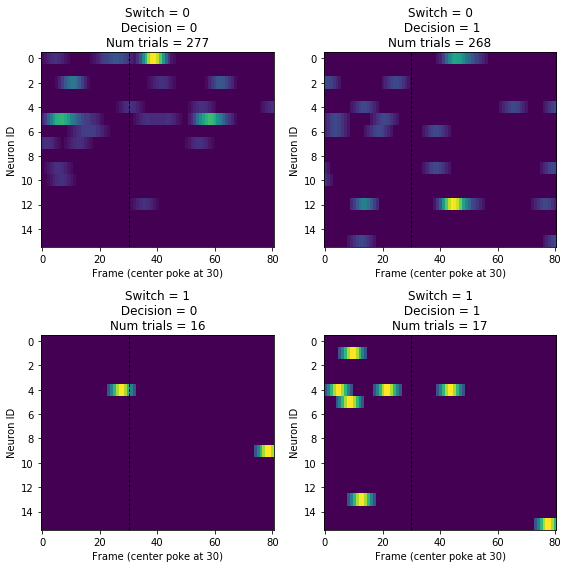

In [122]:
ydim = n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):

    plt.subplot(ydim,2,i+1)  
    plt.imshow(np.transpose(mean_center_poke[:,:,i]))#, plt.colorbar()
    plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
    plt.axis('tight')
    plt.xlabel('Frame (center poke at %s)' % extension)
    plt.ylabel('Neuron ID')
    if n_variables == 3:
        plt.title("%s = %s\n %s = %s\n%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], 
                    conditions[2], poke_frames_keys[i][3], nTrials[i])) 
    if n_variables == 2:
        plt.title("%s = %s\n %s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], nTrials[i]))
    if n_variables == 1:
        plt.title("%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1], nTrials[i]))
plt.tight_layout()

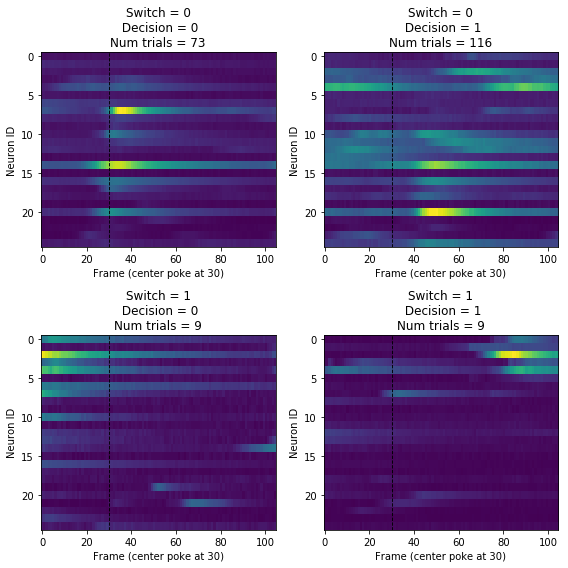

In [90]:
aligned_start_raw = np.zeros((np.max(nTrials), max_window, nNeurons, n_combos))
mean_center_poke_raw = np.zeros((max_window, nNeurons, n_combos))
mean_norm_raw = np.zeros((max_window, nNeurons, n_combos))


for i in range(n_combos):

    # create array containing segment of raw trace for each neuron for each trial 
    # aligned to center poke
    for iNeuron in range(nNeurons): # for each neuron
        for iTrial in range(0,nTrials[i]): # and for each trial
            try:
                aligned_start_raw[iTrial,:, iNeuron, i] = neuron.C_raw[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][0]):
                    (int(poke_frames[poke_frames_keys[i]][iTrial][0])+max_window)]
            except ValueError:
                len_to_end = int(nFrames - poke_frames[poke_frames_keys[i]][iTrial][0])
                aligned_start_raw[iTrial,0:len_to_end, iNeuron, i] = neuron.C_raw[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][0]):
                    (int(poke_frames[poke_frames_keys[i]][iTrial][0])+len_to_end)]
            
    # take mean of fluorescent traces across all trials for each neuron, then normalize
    # for each neuron
    mean_center_poke_raw[:,:,i]= np.mean(aligned_start_raw[0:nTrials[i],:,:,i], axis=0)

    
ydim = n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):

    plt.subplot(ydim,2,i+1)  
    plt.imshow(np.transpose(mean_center_poke_raw[:,:,i]))#, plt.colorbar()
    plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
    plt.axis('tight')
    plt.xlabel('Frame (center poke at %s)' % extension)
    plt.ylabel('Neuron ID')
    if n_variables == 3:
        plt.title("%s = %s\n %s = %s\n%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], 
                    conditions[2], poke_frames_keys[i][3], nTrials[i])) 
    if n_variables == 2:
        plt.title("%s = %s\n %s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], nTrials[i]))
    if n_variables == 1:
        plt.title("%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1], nTrials[i]))
plt.tight_layout()

In [81]:
# Normalize each trace within window being depicted based on single neuron’s activity
# xi - min(x)/(max(x)-min(x)), where max and min are set by activity within window of interest

# reshape so you look at all trials, frames, conditions for each neuron together
aligned_start_flat = aligned_start_raw.reshape(-1, aligned_start_raw.shape[2]) 

# take max and min values for each neuron
raw_min = aligned_start_flat.min(axis = 0)
raw_max = aligned_start_flat.max(axis = 0)

norm_raw = np.zeros_like(aligned_start)
for iNeuron in range(nNeurons):
    norm_raw[:,:,iNeuron,:] = (aligned_start[:,:,iNeuron,:] - raw_min[iNeuron])/(raw_max[iNeuron] - raw_min[iNeuron])


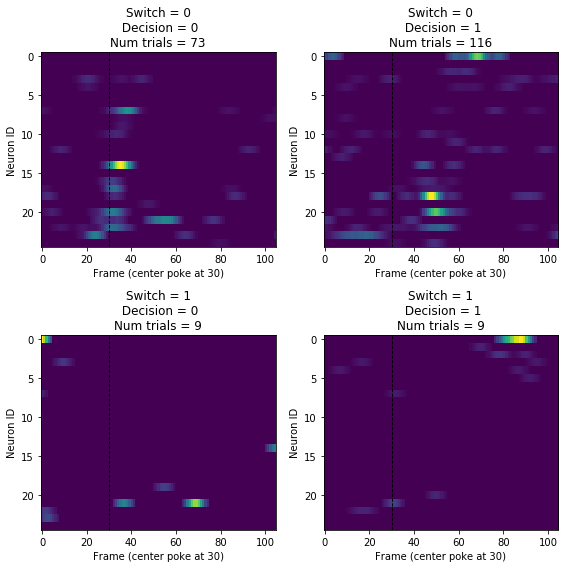

In [89]:
for i in range(n_combos):
    mean_norm_raw[:,:,i]= np.mean(norm_raw[0:nTrials[i],:,:,i], axis=0)

ydim = n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):

    plt.subplot(ydim,2,i+1)  
    plt.imshow(np.transpose(mean_norm_raw[:,:,i]))#, plt.colorbar()
    plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
    plt.axis('tight')
    plt.xlabel('Frame (center poke at %s)' % extension)
    plt.ylabel('Neuron ID')
    if n_variables == 3:
        plt.title("%s = %s\n %s = %s\n%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], 
                    conditions[2], poke_frames_keys[i][3], nTrials[i])) 
    if n_variables == 2:
        plt.title("%s = %s\n %s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], nTrials[i]))
    if n_variables == 1:
        plt.title("%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1], nTrials[i]))
plt.tight_layout()

In [94]:
# Normalize each trace within window being depicted based on all neurons’ activity
aligned_start_flat = aligned_start_raw.ravel()
raw_max = aligned_start_flat.max()
raw_min = aligned_start_flat.min()


norm_raw = np.zeros_like(aligned_start)
for iNeuron in range(nNeurons):
    norm_raw[:,:,iNeuron,:] = (aligned_start[:,:,iNeuron,:] - raw_min)/(raw_max - raw_min)




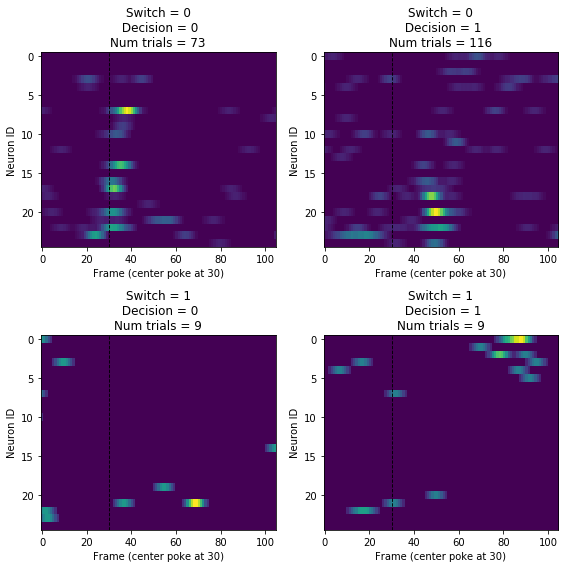

In [95]:
for i in range(n_combos):
    mean_norm_raw[:,:,i]= np.mean(norm_raw[0:nTrials[i],:,:,i], axis=0)

ydim = n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):

    plt.subplot(ydim,2,i+1)  
    plt.imshow(np.transpose(mean_norm_raw[:,:,i]))#, plt.colorbar()
    plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
    plt.axis('tight')
    plt.xlabel('Frame (center poke at %s)' % extension)
    plt.ylabel('Neuron ID')
    if n_variables == 3:
        plt.title("%s = %s\n %s = %s\n%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], 
                    conditions[2], poke_frames_keys[i][3], nTrials[i])) 
    if n_variables == 2:
        plt.title("%s = %s\n %s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], nTrials[i]))
    if n_variables == 1:
        plt.title("%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1], nTrials[i]))
plt.tight_layout()

In [98]:
temp=neuron.C_raw.min(axis=1)
temp.shape

(25,)

In [99]:
# Normalize each trace across entire imaging session based on single neuron’s activity

# take max and min values for each neuron
raw_min = neuron.C_raw.min(axis=1)
raw_max = neuron.C_raw.max(axis=1)

norm_raw = np.zeros_like(aligned_start)
for iNeuron in range(nNeurons):
    norm_raw[:,:,iNeuron,:] = (aligned_start[:,:,iNeuron,:] - raw_min[iNeuron])/(raw_max[iNeuron] - raw_min[iNeuron])

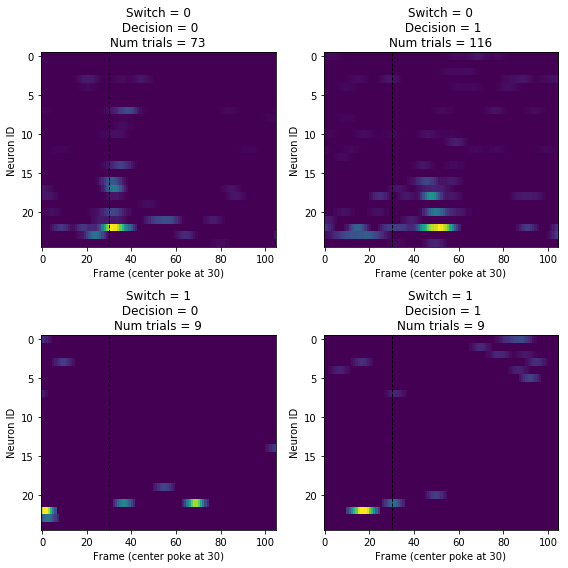

In [100]:
for i in range(n_combos):
    mean_norm_raw[:,:,i]= np.mean(norm_raw[0:nTrials[i],:,:,i], axis=0)

ydim = n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):

    plt.subplot(ydim,2,i+1)  
    plt.imshow(np.transpose(mean_norm_raw[:,:,i]))#, plt.colorbar()
    plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
    plt.axis('tight')
    plt.xlabel('Frame (center poke at %s)' % extension)
    plt.ylabel('Neuron ID')
    if n_variables == 3:
        plt.title("%s = %s\n %s = %s\n%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], 
                    conditions[2], poke_frames_keys[i][3], nTrials[i])) 
    if n_variables == 2:
        plt.title("%s = %s\n %s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1],
                    conditions[1], poke_frames_keys[i][2], nTrials[i]))
    if n_variables == 1:
        plt.title("%s = %s\nNum trials = %.0f" 
                  %(conditions[0], poke_frames_keys[i][1], nTrials[i]))
plt.tight_layout()

In [ ]:
# Normalize each trace across entire imaging session based on all neuron’s activity


In [24]:
temp = mean_decision.sum(axis=1)
[plt.plot(np.transpose(temp[:,c])) for c in range(n_combos)]
plt.axvline(x=max_window-extension, linestyle='--', color='k', linewidth=.9)
plt.axvline(x=max_window-(med_trial_length+extension), linestyle='--', color='k', linewidth=.9)

NameError: name 'mean_decision' is not defined